# Emerging Computer Technologies - quantum task

### Try to get familiar with qiskit transpiler

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock.backends import FakeBrooklyn

In [8]:
backend = FakeBrooklyn()
input_path = './original/adder-3.qasm'

In [9]:
def qasmFromPath(input_path, backend):
    qc = QuantumCircuit.from_qasm_file(path=input_path)
    qc_transpiled = transpile(qc, backend=backend)
    filename = './output/test.qasm'
    qc_transpiled.qasm(filename=filename)
    return qc_transpiled

In [10]:
def qasmOptimization(path, backend):
    qc = QuantumCircuit.from_qasm_file(path=path)
    qc_transpiled = []
    for i in range(3):
        qc_transpiled.append(transpile(qc, backend=backend, optimization_level=i))
        filename = './output/test' + str(i) + '.qasm'
        qc_transpiled[i].qasm(filename=filename)
    return qc_transpiled

### Try to get familiar with circuit's representation

This is the input circuit mapped to the 65qubits fake-device with the Transpiler given by qiskit

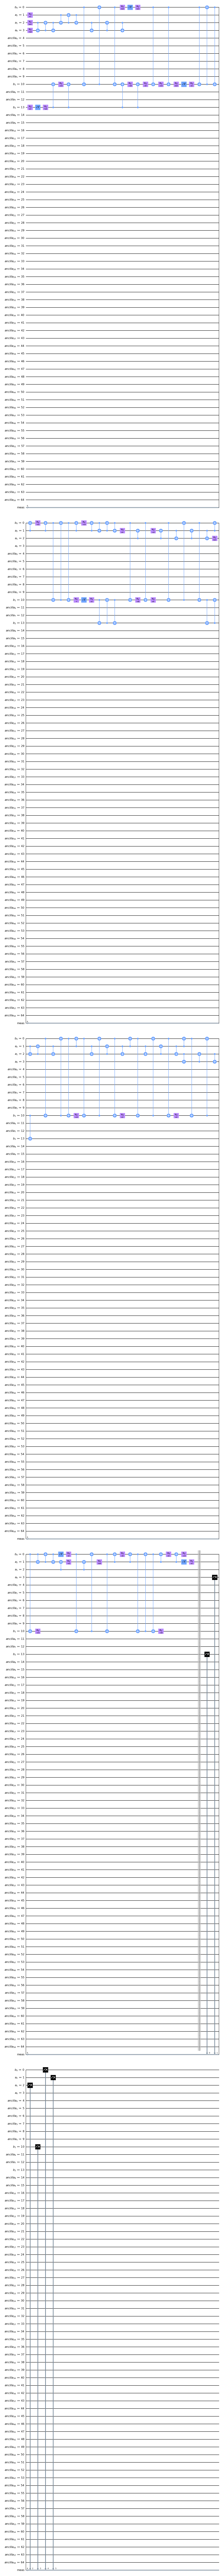

In [11]:
qc_transpiled = qasmFromPath(input_path, backend)
qc_transpiled.draw(output='mpl')

\
\
Let's try to use different kind of transpilers and see the differences in terms of optimization

In [12]:
# TODO try to print several circuits with different optimization
transpilers = qasmOptimization(input_path, backend)
transpilers[0].draw(output='mpl')
for t in transpilers:
    t.draw(output='mpl')

## Try to get familiar with FakeBrooklyn circuit

In [44]:
# take some information on FakeBrooklyn circuit
map = backend.configuration().gates
print(type(map[len(map)-2]))
coupling_list = map[len(map)-2].coupling_map
print('Coupling map -------- \n', type(coupling_list), coupling_list)

print('\n\nBut later I discovered a faster method...\n')
map_easy = backend.configuration().coupling_map
print('coupling easy--', map_easy)

#qubits
num_qubits =  backend.configuration().n_qubits
print('\nnum qubits of device--', num_qubits)

<class 'qiskit.providers.models.backendconfiguration.GateConfig'>
Coupling map -------- 
 <class 'list'> [[0, 1], [0, 10], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 11], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 12], [9, 8], [10, 0], [10, 13], [11, 4], [11, 17], [12, 8], [12, 21], [13, 10], [13, 14], [14, 13], [14, 15], [15, 14], [15, 16], [15, 24], [16, 15], [16, 17], [17, 11], [17, 16], [17, 18], [18, 17], [18, 19], [19, 18], [19, 20], [19, 25], [20, 19], [20, 21], [21, 12], [21, 20], [21, 22], [22, 21], [22, 23], [23, 22], [23, 26], [24, 15], [24, 29], [25, 19], [25, 33], [26, 23], [26, 37], [27, 28], [27, 38], [28, 27], [28, 29], [29, 24], [29, 28], [29, 30], [30, 29], [30, 31], [31, 30], [31, 32], [31, 39], [32, 31], [32, 33], [33, 25], [33, 32], [33, 34], [34, 33], [34, 35], [35, 34], [35, 36], [35, 40], [36, 35], [36, 37], [37, 26], [37, 36], [38, 27], [38, 41], [39, 31], [39, 45], [40, 35], [40, 49], [41, 38], [41, 42], [42, 4

### Understand and use BasicMapper pass (from qiskit)
\
Now I know that I can give an initial_layout like the one described by my device - in practical how many qubits and clbits my final circuit will have. 
\
i.e. The device has 65qubits but the input circuit can have less, so I must **convert the input circuit** (or DAG depending on the representation) **so that it has the same qubits and clbits as the final circuit (the device).**

In [50]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwap(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.

        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.

        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)


        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())
          
        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

## Try to get familiar with DAG from qiskit
\
Let's take a qasm file as input and display his DAG.

QuantumRegister(8, 'a') QuantumRegister(8, 'b')


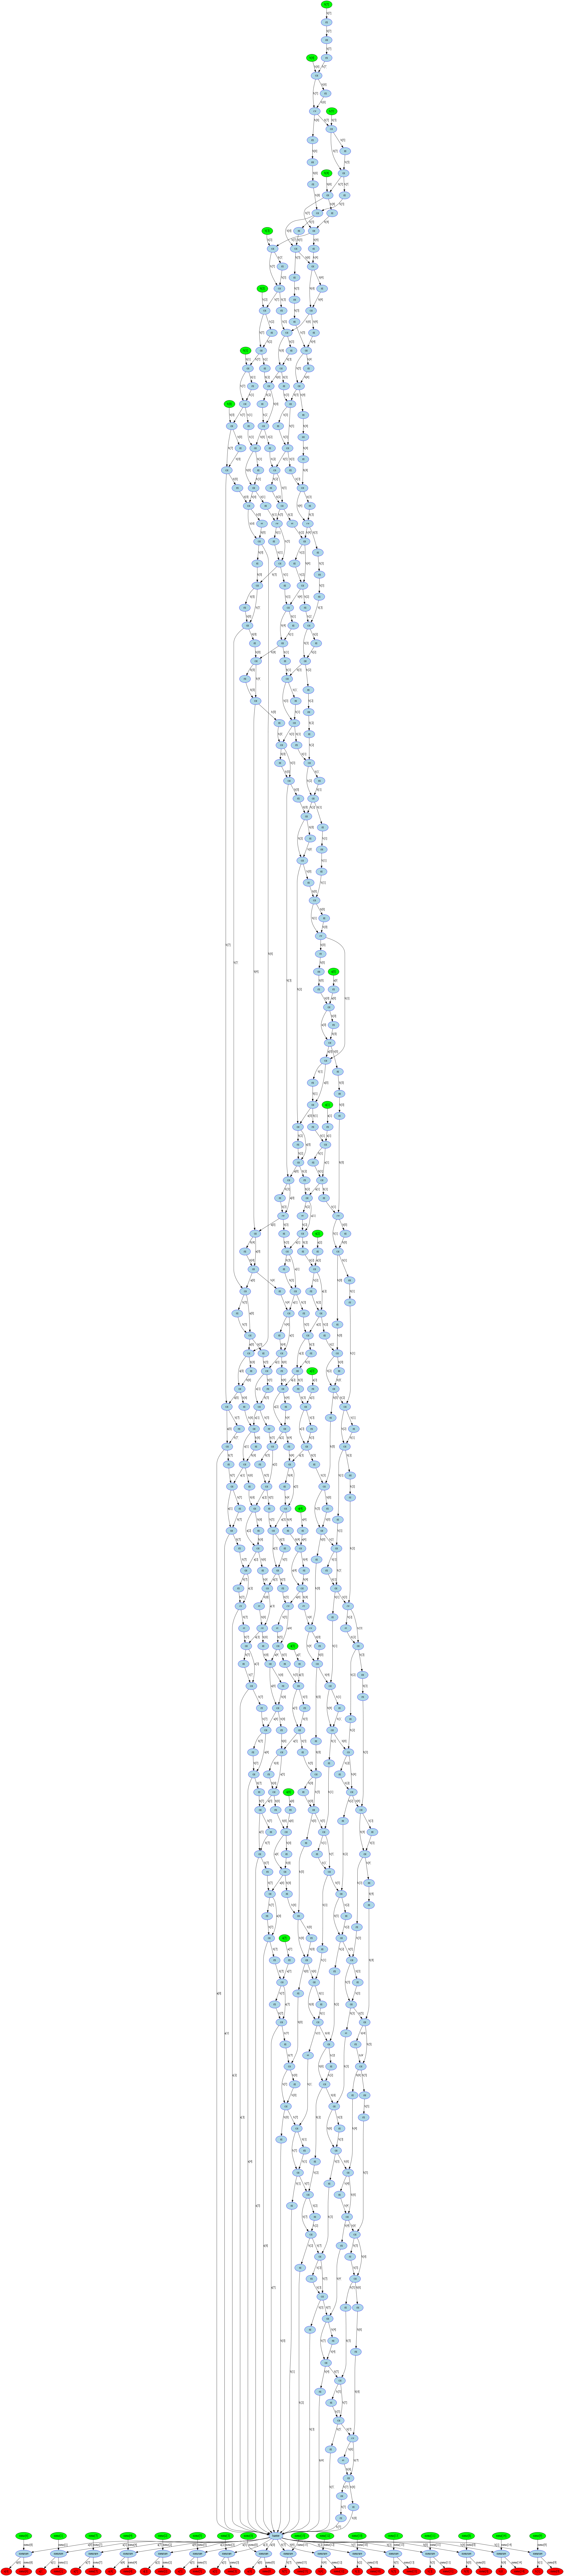

In [47]:
from qiskit.transpiler import CouplingMap
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
from qiskit.dagcircuit import DAGCircuit

%matplotlib inline
input_path = './original/adder-8.qasm'
qc = QuantumCircuit.from_qasm_file(path=input_path)
input_DAG = circuit_to_dag(qc) 
print(*input_DAG.qregs.values())
dag_drawer(input_DAG)

There exists also a representation of the coupling map, and drawing the coupling map of the FakeBrooklyn device you can see how it looks like (i.e. **coupled qubits** in the device)

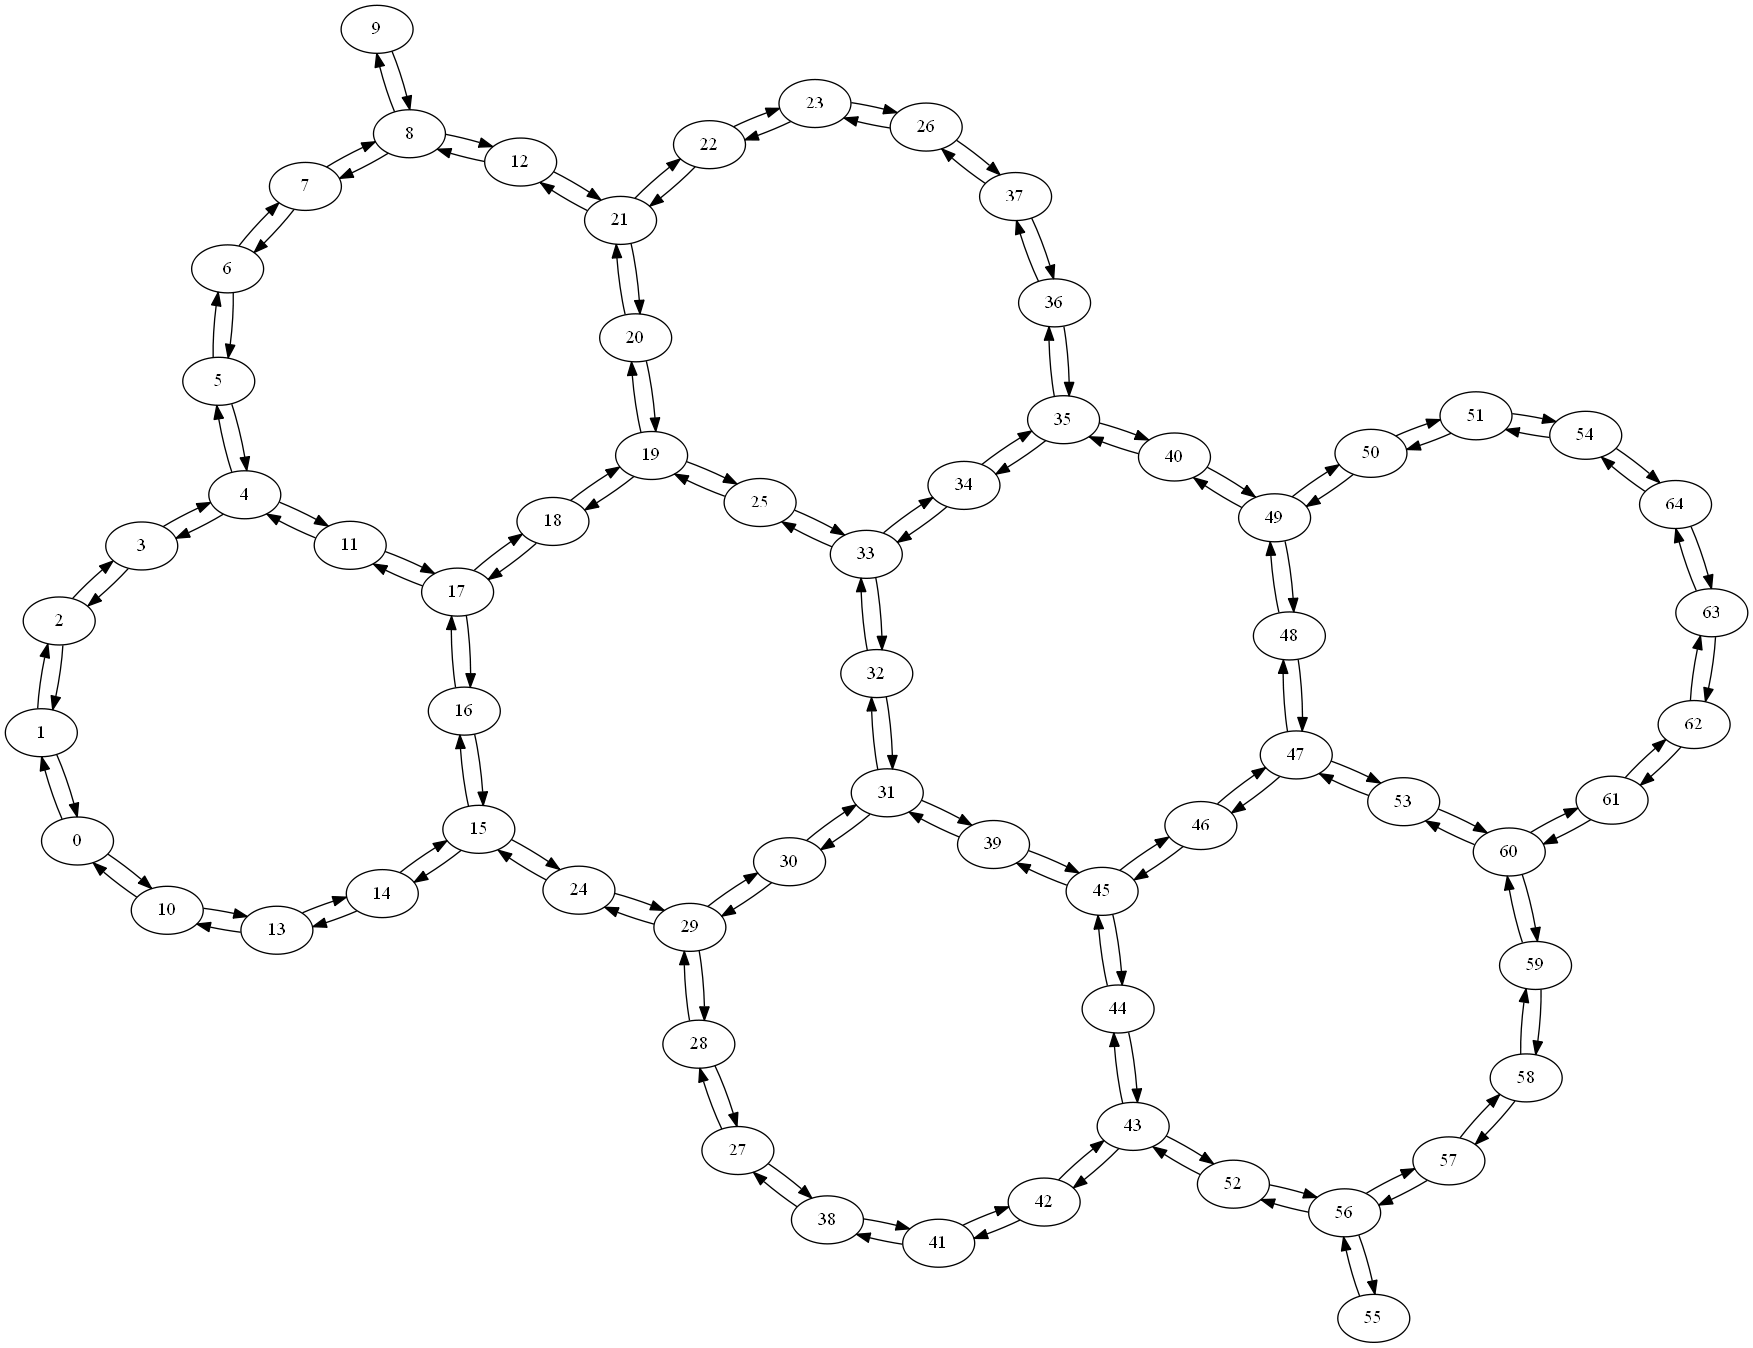

In [48]:
coupling_map = CouplingMap(couplinglist=coupling_list)
coupling_map.draw()

### Let's use the BasicPass!
\
First of all you need to have a DAG of the input circuit that has the same dimension of the device (in terms of qubits and clbits). 
\
Note that a lot of qubits will be unused now, but they can be useful for later optimizations!

In [52]:
from qiskit.transpiler import Layout

# create a circuit the same size as the device, in terms of qubits and clbits
device_qc = QuantumCircuit(num_qubits, num_qubits)
device_DAG = circuit_to_dag(device_qc) 
initial_layout = Layout.generate_trivial_layout(*device_DAG.qregs.values())

#print('qubits--',input_DAG.num_qubits(),input_DAG.num_clbits(), device_DAG.num_qubits(),device_DAG.num_clbits() )
#print(type(device_DAG.qregs.values()))
#print(type(initial_layout))

# build the input_DAG on the device_DAG
device_DAG.compose(input_DAG)
device_DAG.draw()

Now you can **create and run the BasicPass**: it will add **SWAP** gates so that the coupling constraint is satisfied. A lot of gates are added, so we must do subsequent optimizations.
\
Note that the final DAG image is too large, so you have to save it in a file.

In [40]:
basic_pass = BasicSwap(coupling_map, initial_layout)
out_DAG = basic_pass.run(device_DAG)
out_DAG.draw(filename='./output/dag_circuit.jpg')

I must extend the input dag in order to have 65 qubits there..
65 65
65 65 physical number of qubit of the device vs number of qubit allocated


And we can also visualize the corresponding **quantum circuit** with the added SWAP.

In [56]:
from qiskit.converters import dag_to_circuit
final_qc = dag_to_circuit(out_DAG)
final_qc.draw()

┌────────────┐                                                      »
 q_0: ┤ Rz(3.1293) ├──────────────────────────────────────────────────────»
      ├───────────┬┘                                                      »
 q_1: ┤ Rz(3.117) ├───────────────────────────────────────────────────────»
      ├───────────┴┐                                                      »
 q_2: ┤ Rz(3.0925) ├──────────────────────────────────────────────────────»
      ├────────────┤                                                      »
 q_3: ┤ Rz(3.0434) ├──────────────────────────────────────────────────────»
      ├────────────┤                                                      »
 q_4: ┤ Rz(15π/16) ├──────────────────────────────────────────────────────»
      └┬──────────┬┘                                                      »
 q_5: ─┤ Rz(7π/8) ├───────────────────────────────────────────────────────»
       ├──────────┤                                                       »
 q_6: ─┤ Rz(3π/4) ├───────────────────────────────────────────────────────»
       ├─────────┬┘                                                       »
 q_7: ─┤ Rz(π/2) ├────────────────────────────────────────────────────────»
       └─────────┘                                                        »
 q_8: ────────────────────────────────────────────────────────────────────»
                                                                          »
 q_9: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_10: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_11: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_12: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_13: ────────────────────────────────────────────────────────────────────»
                                        ┌───┐┌──────────┐┌───┐┌──────────┐»
q_14: ──────────────────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(3π/4) ├»
       ┌─────────┐  ┌────┐┌────────────┐└─┬─┘└──────────┘└─┬─┘└──────────┘»
q_15: ─┤ Rz(π/2) ├──┤ √X ├┤ Rz(3.1293) ├──■────────────────■──────────────»
       └─────────┘  └────┘└────────────┘                                  »
q_16: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_17: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_18: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_19: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_20: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_21: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_22: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_23: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_24: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_25: ────────────────────────────────────────────────────────────────────»
                                                      

Next step: see the lecture for optimizations!!